In [1]:
import warnings   #------------------------------------------------------
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np
import missingno as msno


from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor 
from lightgbm import LGBMRegressor 

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

#import xgboost as xgb
#import lightgbm as lgb#
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
#1)directory , path   #------------------------------------------------------
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

print(train_data_path)
print(sub_data_path)

/aiffel/aiffel/kaggle_kakr_housing/data/train.csv
/aiffel/aiffel/kaggle_kakr_housing/data/test.csv


In [3]:
#1-1)data read   #------------------------------------------------------

data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [4]:
#0) 9/17 :7:30
data['price'] = np.log1p(data['price'])

In [5]:
#0) 9/17 11:50  .. 이상치
from scipy import stats

#data[(np.abs(stats.zscore(data)) < 3).all(axis=1)]
data[(np.abs(stats.zscore(data['sqft_living'])) > 3)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
98,98,20150401T000000,14.626441,4,3.25,5180,19850,2.0,0,3,...,12,3540,1640,2006,0,98006,47.5620,-122.162,3160,9750
191,191,20150504T000000,14.880222,4,3.25,5050,20100,1.5,0,2,...,11,4750,300,1982,2008,98004,47.6312,-122.223,3890,20060
192,192,20141007T000000,14.126666,4,4.75,5310,57346,2.0,0,0,...,11,5310,0,1989,0,98077,47.7285,-122.042,4180,47443
300,300,20140710T000000,14.253766,5,4.25,6070,171626,2.0,0,0,...,12,6070,0,1999,0,98024,47.5954,-121.950,4680,211267
356,356,20140711T000000,13.880362,6,3.50,4860,11793,2.0,0,0,...,11,3860,1000,1998,0,98006,47.5521,-122.137,3600,11793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14814,14814,20140703T000000,14.670760,4,4.25,5010,19412,2.0,0,1,...,11,4000,1010,2014,0,98040,47.5455,-122.211,3820,17064
14827,14827,20150508T000000,14.508633,4,3.25,5640,35006,2.0,0,2,...,11,4900,740,2015,0,98006,47.5491,-122.104,4920,35033
14928,14928,20141201T000000,14.502389,5,3.50,5230,8960,2.0,0,0,...,11,4450,780,2014,0,98004,47.5964,-122.201,2310,9603
14973,14973,20150407T000000,14.914123,4,3.75,5090,14823,1.0,0,0,...,11,4180,910,2013,0,98004,47.6200,-122.207,3030,12752


In [6]:
#0) 9/17 :7:30
data.loc[data['sqft_living'] > 13000]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8912,8912,20140505T000000,14.639686,7,8.0,13540,307752,3.0,0,4,...,12,9410,4130,1999,0,98053,47.6675,-121.986,4850,217800


In [7]:
#data = data.loc[data['sqft_living']!=8912]
data = data.drop(index=8912, axis=0)


In [8]:
data.loc[(data['price']>12) & (data['grade'] == 3)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2302,2302,20150225T000000,12.476104,1,0.75,520,12981,1.0,0,0,...,3,520,0,1920,0,98022,47.2082,-121.995,1340,12233
4123,4123,20141104T000000,12.542548,1,0.00,600,24501,1.0,0,0,...,3,600,0,1950,0,98045,47.5316,-121.749,990,22549


In [9]:
data.loc[(data['price']>14.7) & (data['grade'] == 8)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
7173,7173,20140813T000000,14.808763,5,4.0,4230,27295,2.0,1,4,...,8,3230,1000,1949,1985,98033,47.6803,-122.214,2660,27295


In [10]:
data.loc[(data['price']>15.5) & (data['grade'] == 11)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2775,2775,20140611T000000,15.77031,5,4.5,10040,37325,2.0,1,2,...,11,7680,2360,1940,2001,98004,47.65,-122.214,3930,25449


In [114]:
#0) 9/17 :7:30
data = data.drop(index=2302, axis=0)
data = data.drop(index=4123, axis=0)
data = data.drop(index=7173, axis=0)
data = data.drop(index=2775, axis=0)



In [11]:
#1-1) data 정리 : y , 정답 분리   #---------------------------------------
y = data['price']
del data['price']

print(data.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [12]:
#1-2) 분석을 위한 정리     train test 합체 > 왜 > 분석 통일성
train_len = len(data)
data = pd.concat((data, sub), axis=0)

print(len(data))

21502


In [13]:
# 2) data 확인 
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


<AxesSubplot:>

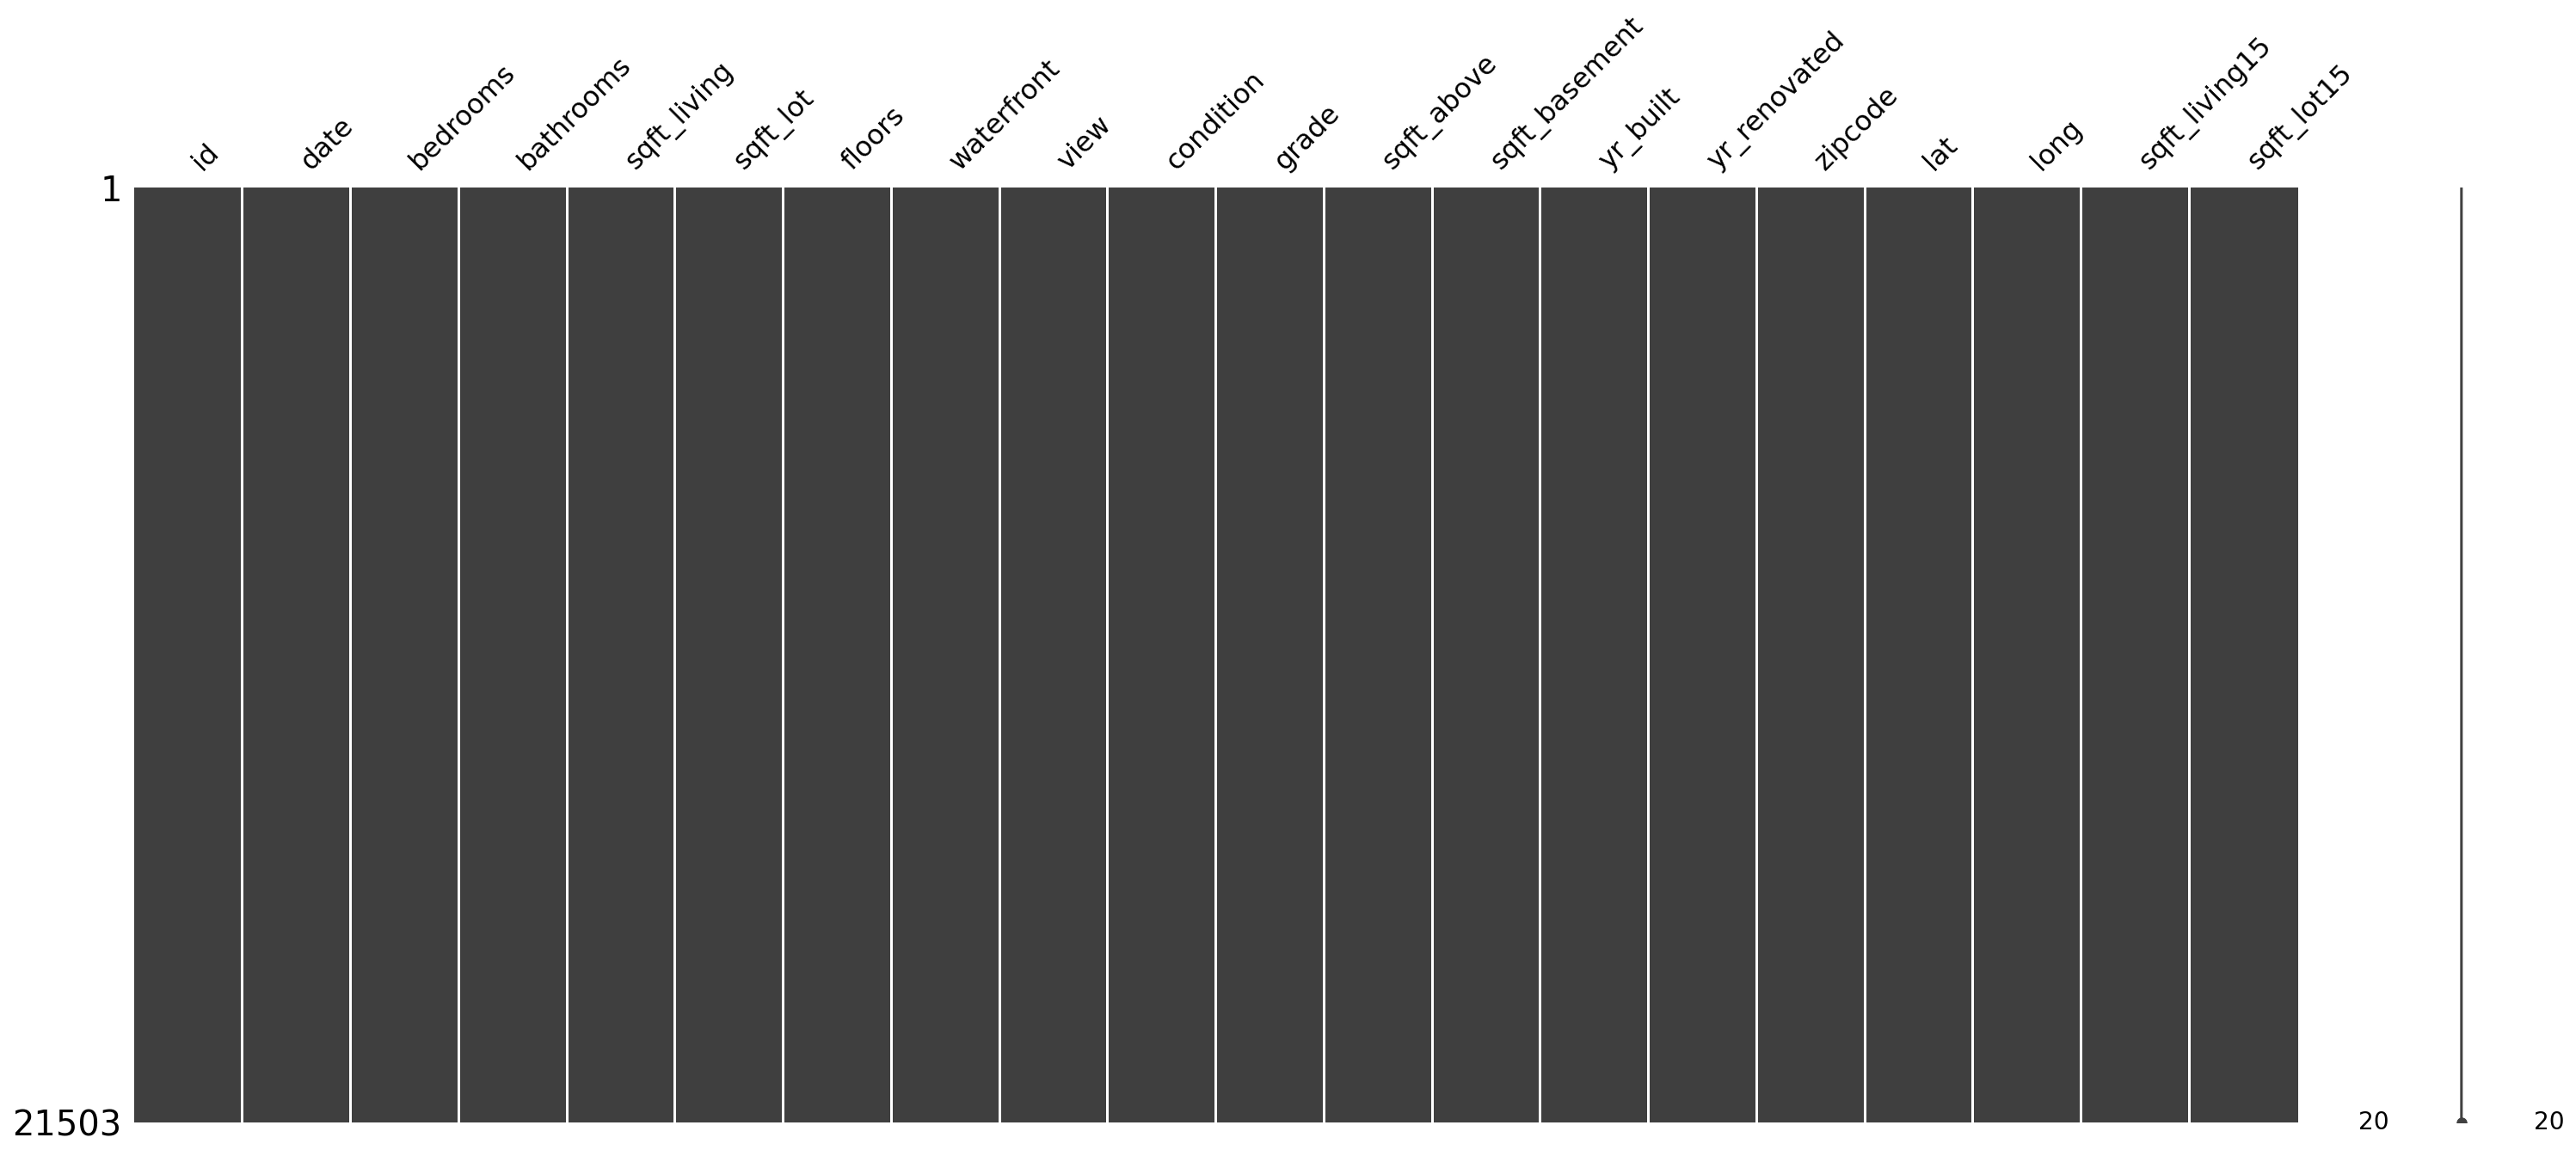

In [8]:
# 2-1) 결측치 확인   ----------------------------------------------
msno.matrix(data)

In [9]:
# 2-1) 결측치
# 1. id 컬럼이 결측치인지 확인합니다.
null_check = pd.isnull(data['id'])
print(null_check)

0       False
1       False
2       False
3       False
4       False
        ...  
6463    False
6464    False
6465    False
6466    False
6467    False
Name: id, Length: 21503, dtype: bool


In [10]:
# 2-1) 결측치인 데이터만 뽑아냅니다.  ---------------------
null_data = data.loc[null_check, 'id']
null_data.head()

Series([], Name: id, dtype: int64)

In [11]:
# 2-1) 결측치            x---------------------------------------
print('{}: {}'.format('id', len(null_data.values)))

# 한 번에 뿅!  > 2-1)  + 2-2)
print('{} : {}'.format('id', len(data.loc[pd.isnull(data['id']), 'id'].values)))

id: 0
id : 0


In [12]:
#전체    ... 필요 --------------------------------------------------
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


In [74]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21503 entries, 0 to 6467
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21503 non-null  int64  
 1   date           21503 non-null  object 
 2   bedrooms       21503 non-null  int64  
 3   bathrooms      21503 non-null  float64
 4   sqft_living    21503 non-null  int64  
 5   sqft_lot       21503 non-null  int64  
 6   floors         21503 non-null  float64
 7   waterfront     21503 non-null  int64  
 8   view           21503 non-null  int64  
 9   condition      21503 non-null  int64  
 10  grade          21503 non-null  int64  
 11  sqft_above     21503 non-null  int64  
 12  sqft_basement  21503 non-null  int64  
 13  yr_built       21503 non-null  int64  
 14  yr_renovated   21503 non-null  int64  
 15  zipcode        21503 non-null  int64  
 16  lat            21503 non-null  float64
 17  long           21503 non-null  float64
 18  sqft_li

In [17]:
#0) outlier 제거  9/17 :7:30
def outlier(data, col, z):
    return data[abs(data[col] - np.mean(data[col]))/np.std(data[col])>z].index

data.loc[outlier(data, 'sqft_living', 1.5)]
#trade.loc[outlier(data, 'sqft_living', 2)]
#trade.loc[outlier(data, 'sqft_living', 3)]



SyntaxError: invalid non-printable character U+00A0 (723869672.py, line 3)

In [118]:
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


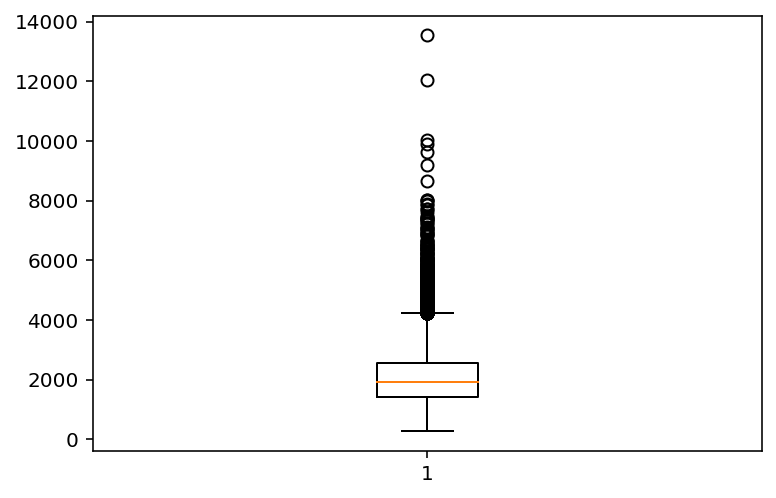

In [71]:
fig, ax = plt.subplots()
ax.boxplot(data['sqft_living'])
plt.show()


In [14]:
#3) column 정리   -- id제거 
sub_id = data['id'][train_len:]
del data['id']

print(data.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [15]:
del sub['id']
sub.columns

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [16]:
#4) data 전처리   .. data obkect  > str
data['date'] = data['date'].apply(lambda x : str(x[:6]))

data.head()


,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [17]:
sub['date'] = sub['date'].apply(lambda x : str(x[:6]))

sub.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201412,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,201412,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,201405,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,201504,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,201503,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21502 entries, 0 to 6467
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21502 non-null  object 
 1   bedrooms       21502 non-null  int64  
 2   bathrooms      21502 non-null  float64
 3   sqft_living    21502 non-null  int64  
 4   sqft_lot       21502 non-null  int64  
 5   floors         21502 non-null  float64
 6   waterfront     21502 non-null  int64  
 7   view           21502 non-null  int64  
 8   condition      21502 non-null  int64  
 9   grade          21502 non-null  int64  
 10  sqft_above     21502 non-null  int64  
 11  sqft_basement  21502 non-null  int64  
 12  yr_built       21502 non-null  int64  
 13  yr_renovated   21502 non-null  int64  
 14  zipcode        21502 non-null  int64  
 15  lat            21502 non-null  float64
 16  long           21502 non-null  float64
 17  sqft_living15  21502 non-null  int64  
 18  sqft_lo

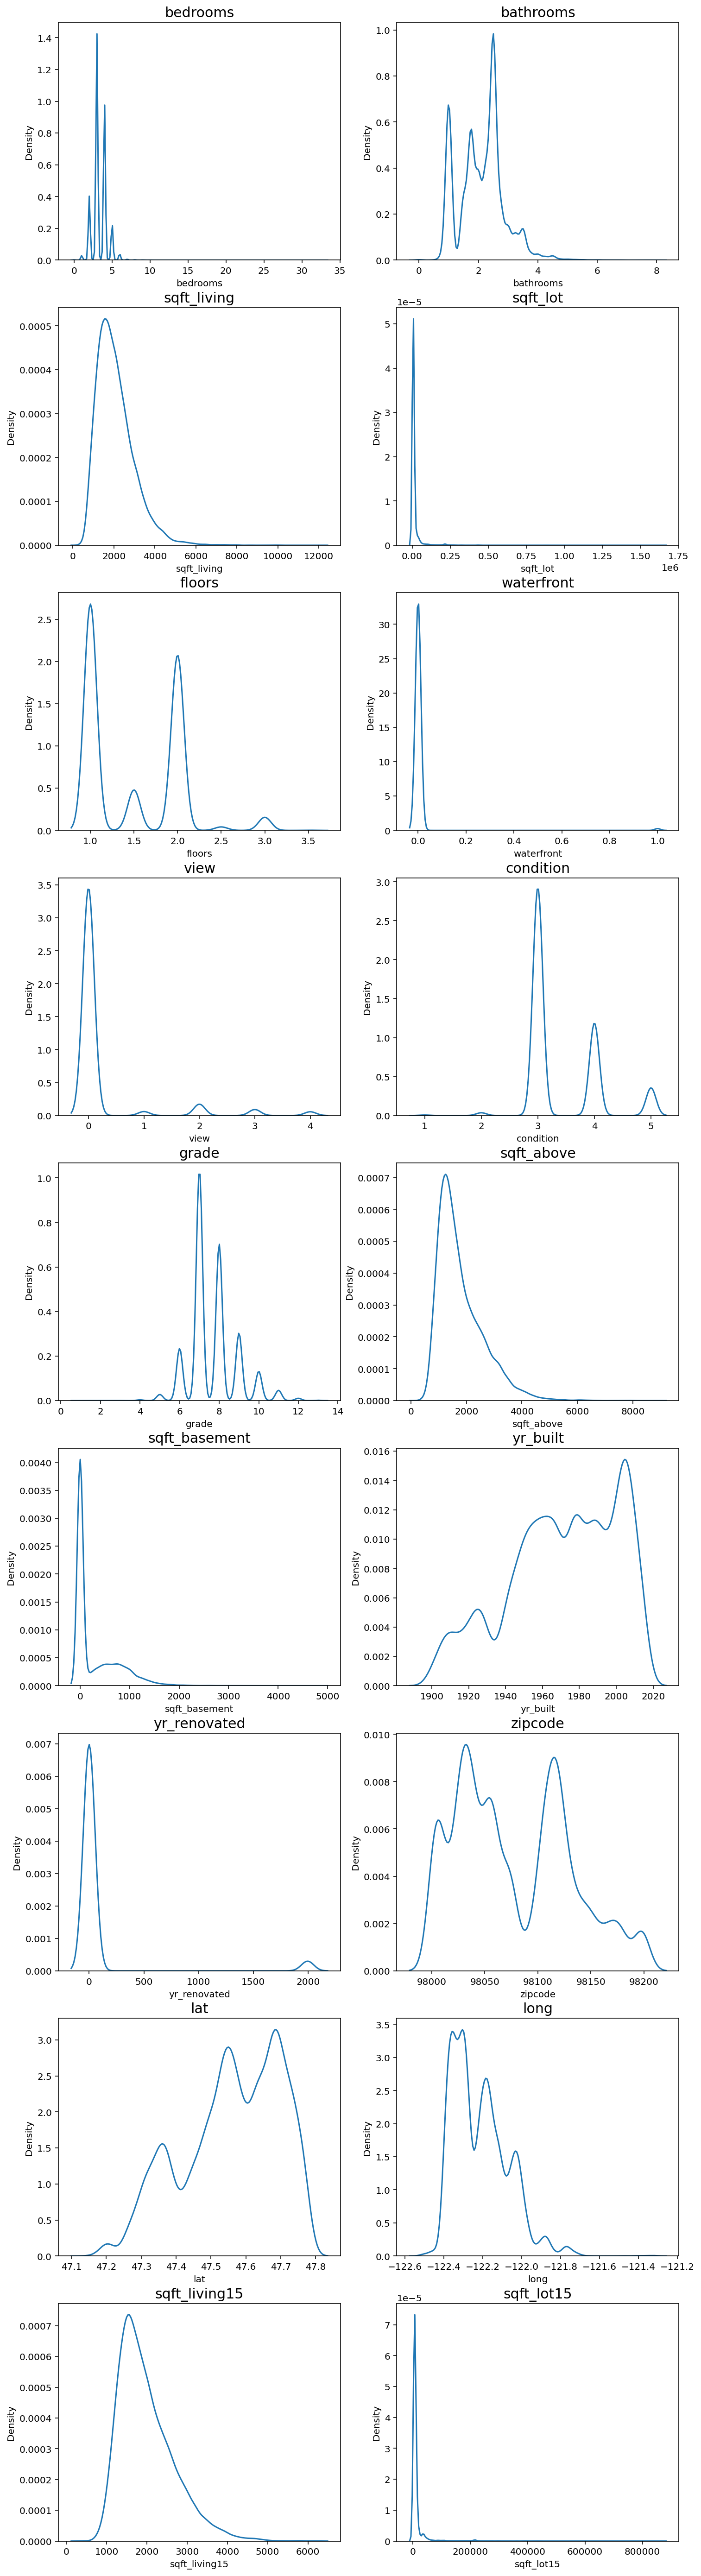

In [19]:
# 5) data 호가인 grapes ............... 중요 log변환  bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement, sqft_living15, sqft_lot15
# 아래거 하 ㄴ후 다시
fig, ax = plt.subplots(9, 2, figsize=(12, 50))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

In [125]:
# # 5) data 호가인  치우침 log   7개 ,,,,,,,,,,,,, 
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

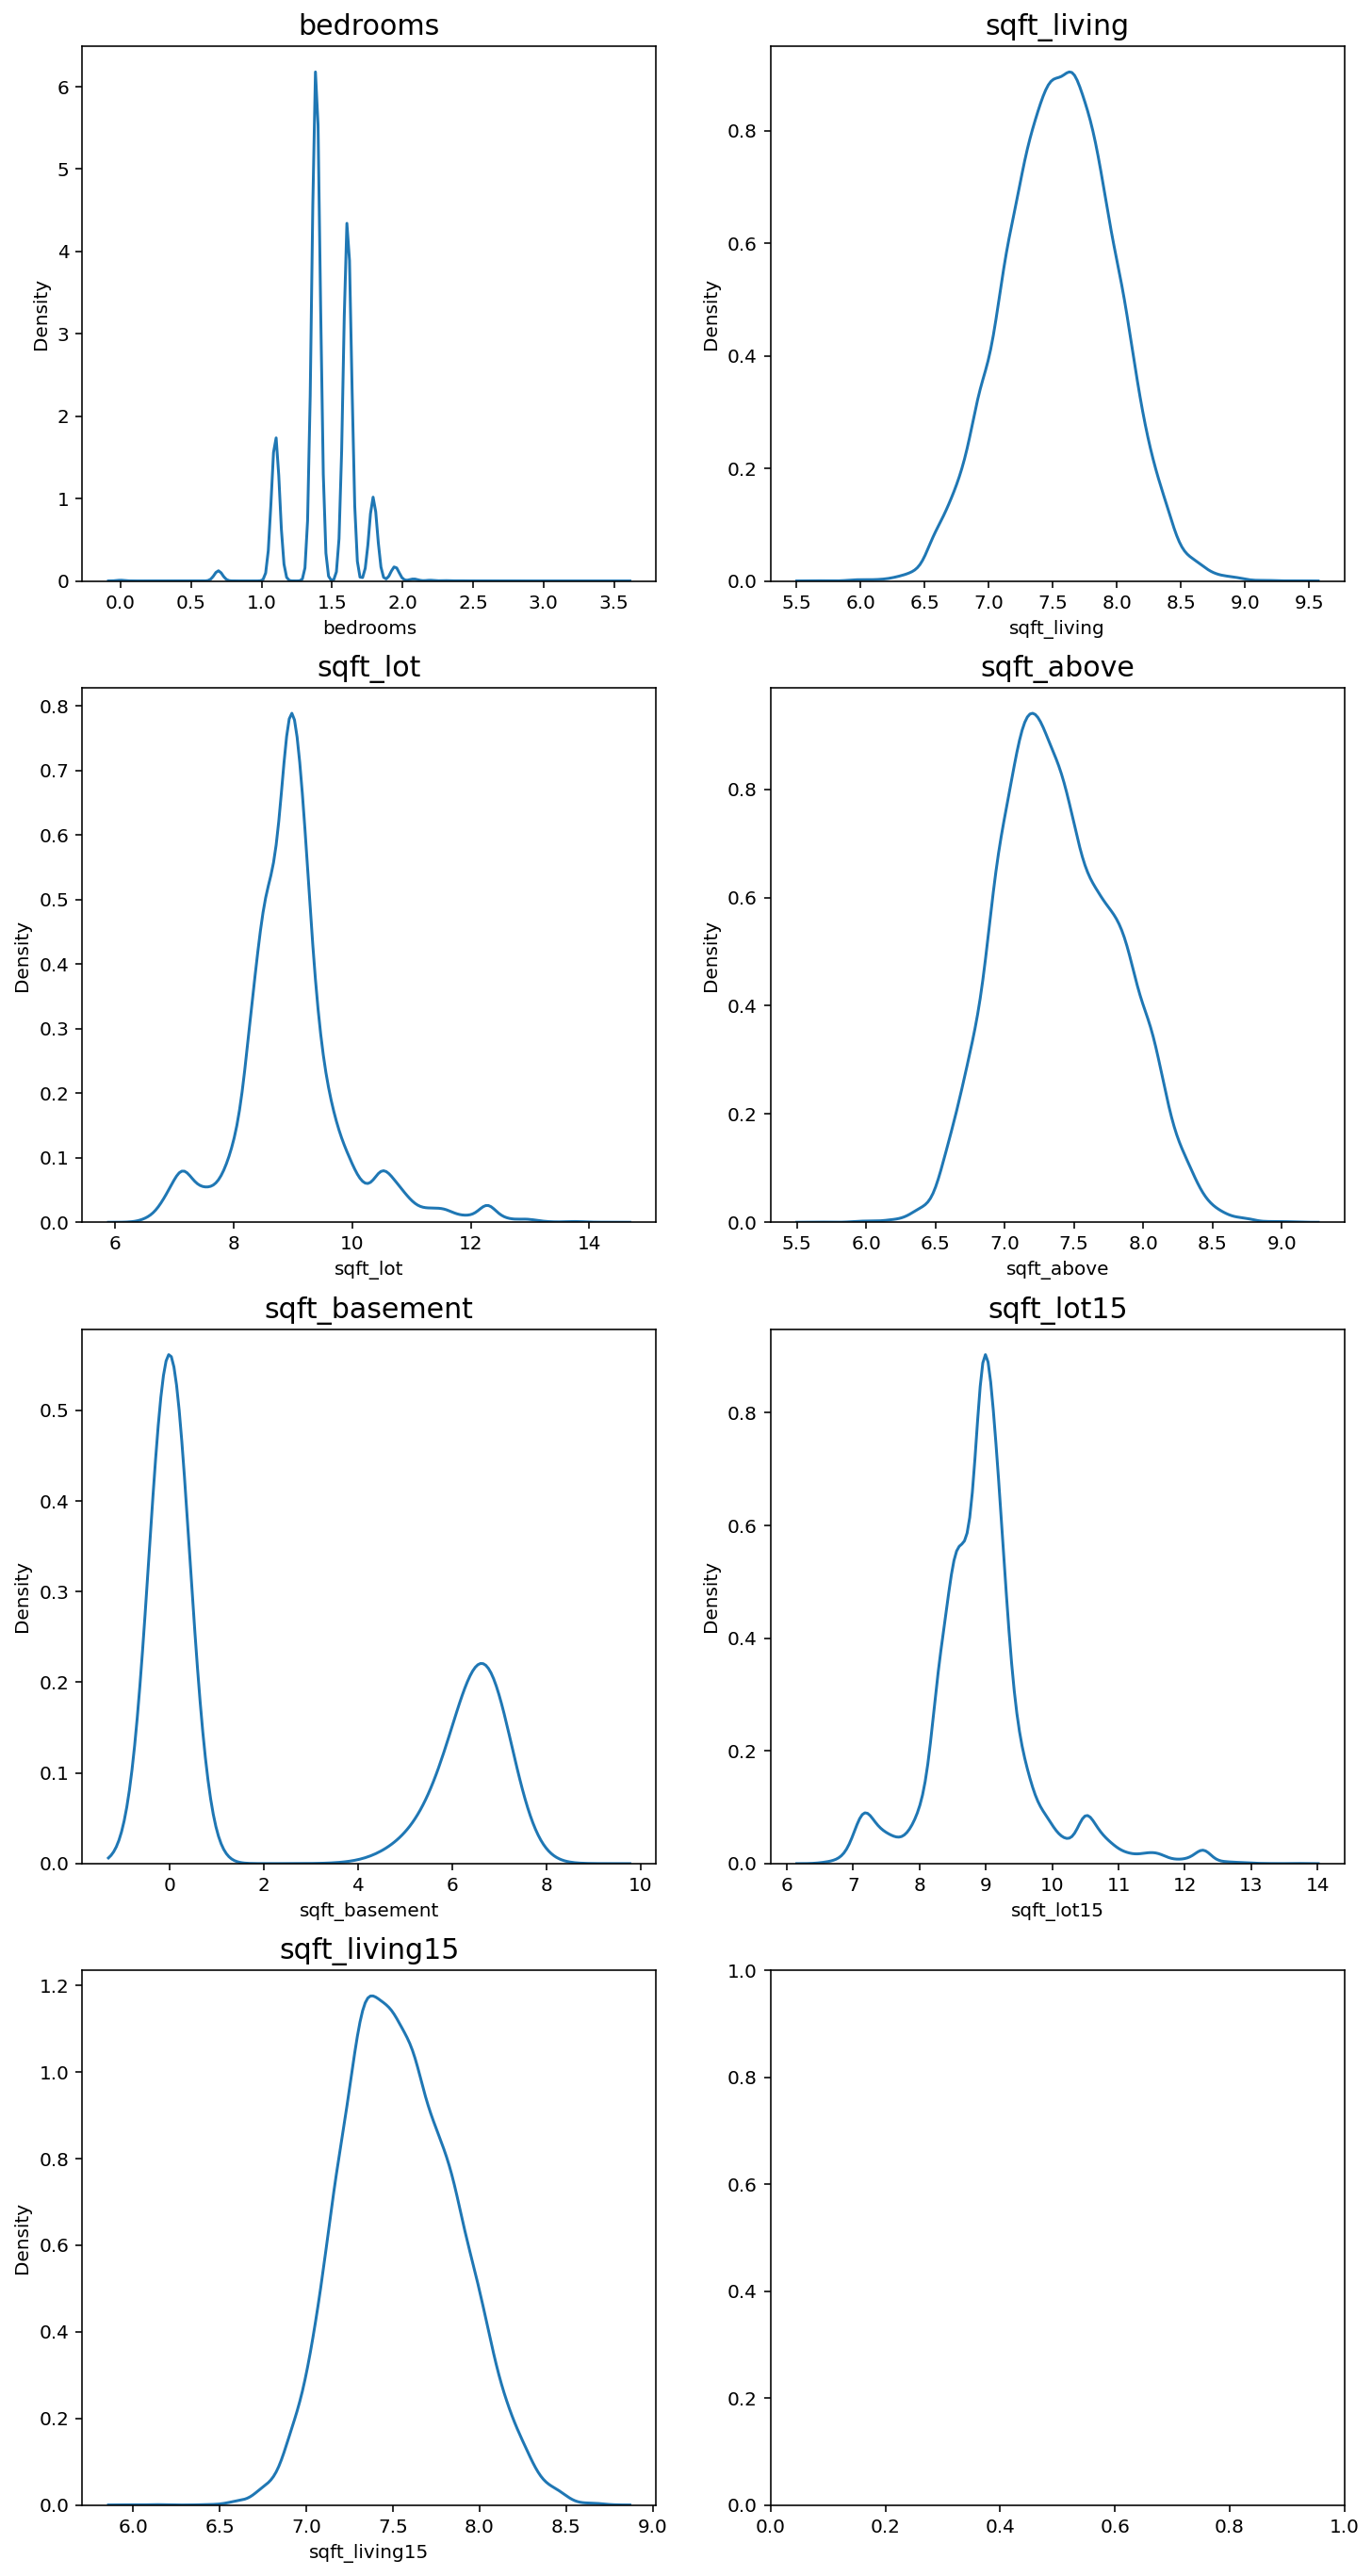

In [126]:
# # 5) data 호가인  치우침 log   7개 ,
fig, ax = plt.subplots(4, 2, figsize=(12, 24))

count = 0
for row in range(4):
    for col in range(2):
        if count == 7:
            break
        sns.kdeplot(data=data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

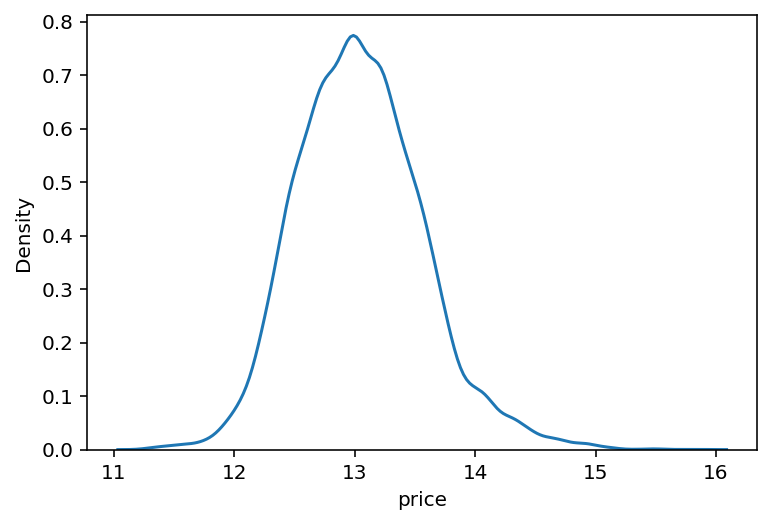

In [127]:
#50 price 확인 
sns.kdeplot(y)
plt.show()

In [128]:
#6 ) data 재분리   1-2) 분리 한 대로 
#sub = data.iloc[train_len:, :]
#x = data.iloc[:train_len, :]

print(data.shape)
print(sub.shape)

(21498, 19)
(6468, 19)


In [129]:
import xgboost as xgb
import lightgbm as lgb 
#import rdforest as rfr

gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(max_depth=10, n_estimators=100,random_state=2019)
rdforest = RandomForestRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}, {'model':rdforest, 'name':'RandomForest'}]


In [130]:
#모델 검증 .. 필요 없음 
def get_cv_score(models):
    kfold = KFold(n_splits=5).get_n_splits(x.values)
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X=x.values, y=y, cv=kfold))
        print(f"Model: {m['name']}, CV score:{CV_score:.4f}")
print('얍💢')

얍💢


In [131]:
##모델 검증 .. 필요 없음 
get_cv_score(models)

Model: GradientBoosting, CV score:0.8791
Model: XGBoost, CV score:0.8964
Model: LightGBM, CV score:0.9024
Model: RandomForest, CV score:0.8853


In [132]:
# 블렌딩 모델 defe
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
   
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)


In [133]:
# 예측갑에 블랜딩 모델 
y_pred = AveragingBlending(models, x, y, sub)
print(len(y_pred))
y_pred

6468


array([13.66042376, 13.67386945, 14.37071212, ..., 14.16454111,
       14.02827277, 13.93274836])

In [136]:
y_pred = np.expm1(y_pred)
y_pred


6468

In [137]:
# submission file 확인 
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()


,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [138]:
#submission 만들기
result = pd.DataFrame({
    'id' : sub_id, 
    'price' : y_pred
})

result.head()

,id,price
0,15035,8.563398e+05
1,15036,8.679317e+05
2,15037,1.742291e+06
3,15038,6.907904e+05
4,15039,7.159784e+05


In [139]:
#submission 만들기 2
my_submission_path = join(data_dir, 'submission06.csv')
result.to_csv(my_submission_path, index=False)

print(my_submission_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission06.csv
